# Named Entity Recognition with LSTM

In this homework we'll explore how we can use Deep Learning for sequence labelling tasks such as part-of-speech tagging or named entity recognition. 

## Data



For our experiments we'll reuse the Dutch CoNLL-2002 data has four kinds of named entities (people, locations, organizations and miscellaneous entities) and comes split into a training, development and test set. 

Loading the dataset

In [1]:
# Importing data from conll2002 dataset
import nltk
nltk.download('conll2002')

train_sents = list(nltk.corpus.conll2002.iob_sents('ned.train'))
dev_sents = list(nltk.corpus.conll2002.iob_sents('ned.testa'))
test_sents = list(nltk.corpus.conll2002.iob_sents('ned.testb'))

train_sents[:3]

[nltk_data] Downloading package conll2002 to
[nltk_data]     /Users/mrunalikhandat/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


[[('De', 'Art', 'O'),
  ('tekst', 'N', 'O'),
  ('van', 'Prep', 'O'),
  ('het', 'Art', 'O'),
  ('arrest', 'N', 'O'),
  ('is', 'V', 'O'),
  ('nog', 'Adv', 'O'),
  ('niet', 'Adv', 'O'),
  ('schriftelijk', 'Adj', 'O'),
  ('beschikbaar', 'Adj', 'O'),
  ('maar', 'Conj', 'O'),
  ('het', 'Art', 'O'),
  ('bericht', 'N', 'O'),
  ('werd', 'V', 'O'),
  ('alvast', 'Adv', 'O'),
  ('bekendgemaakt', 'V', 'O'),
  ('door', 'Prep', 'O'),
  ('een', 'Art', 'O'),
  ('communicatiebureau', 'N', 'O'),
  ('dat', 'Conj', 'O'),
  ('Floralux', 'N', 'B-ORG'),
  ('inhuurde', 'V', 'O'),
  ('.', 'Punc', 'O')],
 [('In', 'Prep', 'O'),
  ("'81", 'Num', 'O'),
  ('regulariseert', 'V', 'O'),
  ('de', 'Art', 'O'),
  ('toenmalige', 'Adj', 'O'),
  ('Vlaamse', 'Adj', 'B-MISC'),
  ('regering', 'N', 'O'),
  ('de', 'Art', 'O'),
  ('toestand', 'N', 'O'),
  ('met', 'Prep', 'O'),
  ('een', 'Art', 'O'),
  ('BPA', 'N', 'B-MISC'),
  ('dat', 'Pron', 'O'),
  ('het', 'Art', 'O'),
  ('bedrijf', 'N', 'O'),
  ('op', 'Prep', 'O'),
  ('eigen', 

Could you explain A bidirectional LSTM (BiLSTM) (30%)

### Bidirectional LSTM-

Bidirectional LSTM stands for Bidirectional Long Short Term Memory structures. LSTMs are basically Recurrent Neural Networks. LSTMs are used to predict the next element after the current element. Forward LSTMs use the previous elements to predict the next element. Whereas Backward LSTMs use the next elements in the training dataset to predict the next element after the current element.
  
      Consider an example, I am Peter ____ is what he says

Forward LSTMs will use 'I am' to predict the blank. Whereas, Backward LSTMs will use 'is what he says' to make a prediction of the blank space. Bi-LSTM combines outputs from both and gives a final output. Bi-LSTMs are useful in NLP as context of the sentence can be conveyed by both before and after parts of the blank.   
Bi-LSTMs are used in both supervised and unsupervised learning algorithms. Bi-LSTMs are achieved by feeding the data in forward and backward manner. Bi-LSTMs are faster and achieve better results.


In [2]:
from torchtext.data import Example
from torchtext.data import Field, Dataset

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

def read_data(sentences):
    """
    Returns datasets with labels and tokens
    
    """
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for sentence in sentences: 
        tokens = [t[0] for t in sentence]
        labels = [t[2] for t in sentence]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])

train_data = read_data(train_sents)
dev_data = read_data(dev_sents)
test_data = read_data(test_sents)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(dev_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x1066ffbd0>, 'text': <torchtext.data.field.Field object at 0x1066ff910>}
['De', 'tekst', 'van', 'het', 'arrest', 'is', 'nog', 'niet', 'schriftelijk', 'beschikbaar', 'maar', 'het', 'bericht', 'werd', 'alvast', 'bekendgemaakt', 'door', 'een', 'communicatiebureau', 'dat', 'Floralux', 'inhuurde', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']
Train: 15806
Dev: 2895
Test: 5195


In [3]:
# Building vocab from training data
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [4]:
from torchtext.data import BucketIterator
# Getting iterator using data; iterator is used for training, testing LSTMs
BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
dev_iter = BucketIterator(dataset=dev_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)


In [6]:
import random
import os
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBEDDING_PATH = os.path.join(os.path.expanduser("~"), "Downloads/cc.nl.300.vec")

def load_embeddings(path):
    """ 
    Load the FastText embeddings from the embedding file. 
    Output- Embeddings as a dictionary
    
    """
    print("Loading pre-trained embeddings")
    
    embeddings = {}
    with open(EMBEDDING_PATH) as i:
        for line in i:
            if len(line) > 2: 
                line = line.strip().split()
                word = line[0]
                embedding = np.array(line[1:])
                embeddings[word] = embedding
    
    return embeddings
    

def initialize_embeddings(embeddings, vocabulary):
    """ 
    Use the pre-trained embeddings to initialize an embedding matrix.
    Output- embedding matrix so that words in embeddings can be accessed
            by their index. Index of a word in vocab and embedding matrix is same
    
    """
    print("Initializing embedding matrix")
    embedding_size = len(embeddings["."])
    embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                
    for idx, word in enumerate(vocabulary.itos): 
        if word in embeddings:
            embedding_matrix[idx,:] = embeddings[word]
            
    return embedding_matrix

embeddings = load_embeddings(EMBEDDING_PATH)
embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
embedding_matrix = torch.from_numpy(embedding_matrix).to(device)

Loading pre-trained embeddings
Initializing embedding matrix


## Model (70%)

Next, we create our BiLSTM model. It consists of four layers:
    
- An embedding layer that maps one-hot word vectors to dense word embeddings. These embeddings are either pretrained or trained from scratch.
- A bidirectional LSTM layer that reads the text both front to back and back to front. For each word, this LSTM produces two output vectors of dimensionality `hidden_dim`, which are concatenated to a vector of `2*hidden_dim`.
- A dropout layer that helps us avoid overfitting by dropping a certain percentage of the items in the LSTM output.
- A dense layer that projects the LSTM output to an output vector with a dimensionality equal to the number of labels.

Could you try to apply your desgined BiLSTM model to do NER labeling?


In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTM, self).__init__()
        
        # Embedding Layer- used pretrained word embeddings
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # LSTM Layer- Use bidirectional= True for BiLSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # dropout layer- To avoid overfitting
        self.dropout_layer = nn.Dropout(p=0.25)

        # Dense Layer- A fully connected layer to get tags
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [8]:
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report


def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask


def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    """
    Training model
    
    """
    
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            # Clear initial weights
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward() 
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)
        
        dev_f = dev_scores[2]
        # If development F-score does not improve in consecutive patience value, then stop training
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model as Development F-score improved.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score did not improve for last ",no_improvement," epochs. Stop training!")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

In [9]:
def test(model, test_iter, batch_size, labels, target_names): 
    """
    Test model
    
    """
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                               correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))


In [10]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
MAX_EPOCHS = 50
PATIENCE = 3
OUTPUT_PATH = "/tmp/bilstm"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  

train_f, dev_f = train(tagger.to(device), train_iter, dev_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

/Users/mrunalikhandat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Total training loss: 213.36526759713888
Training performance: (0.9285249008112749, 0.9285249008112749, 0.9285249008112749, None)
Total development loss: 24.779741942882538
Development performance: (0.929790113301669, 0.929790113301669, 0.929790113301669, None)
Saving model as Development F-score improved.


/Users/mrunalikhandat/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Total training loss: 66.26967169297859
Training performance: (0.9620319377825152, 0.9620319377825152, 0.9620319377825152, None)
Total development loss: 17.876843596808612
Development performance: (0.9411998832488656, 0.9411998832488656, 0.9411998832488656, None)
Saving model as Development F-score improved.



Total training loss: 46.88644802197814
Training performance: (0.9705592072797615, 0.9705592072797615, 0.9705592072797615, None)
Total development loss: 18.160010691266507
Development performance: (0.9409876084591504, 0.9409876084591504, 0.9409876084591504, None)



Total training loss: 38.095161547418684
Training performance: (0.9748820591776712, 0.9748820591776712, 0.9748820591776712, None)
Total development loss: 16.179212007438764
Development performance: (0.9452331042534561, 0.9452331042534561, 0.9452331042534561, None)
Saving model as Development F-score improved.



Total training loss: 32.10703522944823
Training performance: (0.9777146128185389, 0.9777146128185389, 0.9777146128185389, None)
Total development loss: 18.099692140356638
Development performance: (0.9446228142330246, 0.9446228142330246, 0.9446228142330246, None)



Total training loss: 27.631763985438738
Training performance: (0.980256015475415, 0.980256015475415, 0.980256015475415, None)
Total development loss: 17.75517588527873
Development performance: (0.9447024172791679, 0.9447024172791679, 0.9447024172791679, None)



Total training loss: 24.32579001504928
Training performance: (0.9820177256666864, 0.9820177256666864, 0.9820177256666864, None)
Total development loss: 14.740148649085313
Development performance: (0.9490009817709024, 0.9490009817709024, 0.9490009817709024, None)
Saving model as Development F-score improved.



Total training loss: 21.339181425908464
Training performance: (0.9837942401452794, 0.9837942401452794, 0.9837942401452794, None)
Total development loss: 16.808311138360295
Development performance: (0.947621195637753, 0.947621195637753, 0.947621195637753, None)



Total training loss: 18.903283227438806
Training performance: (0.985245060302797, 0.985245060302797, 0.985245060302797, None)
Total development loss: 16.67431971116457
Development performance: (0.9482845543556133, 0.9482845543556133, 0.9482845543556133, None)



Total training loss: 17.076296232728055
Training performance: (0.9864195337636447, 0.9864195337636447, 0.9864195337636447, None)
Total development loss: 15.731329553993419
Development performance: (0.9502480961604798, 0.9502480961604798, 0.9502480961604798, None)
Saving model as Development F-score improved.



Total training loss: 15.140395860085846
Training performance: (0.9876038767493733, 0.9876038767493733, 0.9876038767493733, None)
Total development loss: 17.4563724522377
Development performance: (0.9492663252580466, 0.9492663252580466, 0.9492663252580466, None)



Total training loss: 13.481919855301385
Training performance: (0.9888128935473046, 0.9888128935473046, 0.9888128935473046, None)
Total development loss: 16.9878794598917
Development performance: (0.9495316687451907, 0.9495316687451907, 0.9495316687451907, None)



Total training loss: 11.67038989529101
Training performance: (0.9903229308541087, 0.9903229308541087, 0.9903229308541087, None)
Total development loss: 18.92997093341546
Development performance: (0.9495051343964762, 0.9495051343964762, 0.9495051343964762, None)



Total training loss: 10.38216796163033
Training performance: (0.9912259923807268, 0.9912259923807268, 0.9912259923807268, None)
Total development loss: 18.53918498835992
Development performance: (0.9488683100273304, 0.9488683100273304, 0.9488683100273304, None)
Development F-score did not improve for last  4  epochs. Stop training!


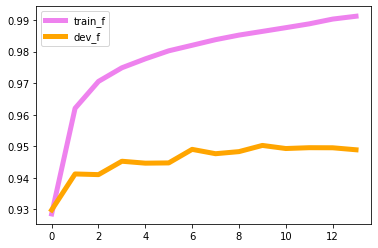

In [11]:
%matplotlib notebook
%matplotlib inline
# Plot performance of the model through epochs
import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'dev_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='violet', linewidth=5)
plt.plot('epochs', 'dev_f', data=df, color='orange', linewidth=5)
plt.legend()
plt.show()

In [12]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTM(
  (embeddings): Embedding(20002, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=11, bias=True)
)

In [13]:
# Performance evaluation report of the BiLSTM model
labels = label_field.vocab.itos[3:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]
print("*"*60)
print("\t\t\tPerformance Evaluation")
print("*"*60)

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

************************************************************
			Performance Evaluation
************************************************************
              precision    recall  f1-score   support

       B-LOC       0.86      0.66      0.75       774
       I-LOC       0.48      0.51      0.50        49
      B-MISC       0.85      0.48      0.61      1187
      I-MISC       0.70      0.27      0.39       410
       B-ORG       0.83      0.51      0.63       882
       I-ORG       0.86      0.49      0.63       551
       B-PER       0.87      0.65      0.74      1098
       I-PER       0.95      0.71      0.81       807

   micro avg       0.86      0.56      0.68      5758
   macro avg       0.80      0.53      0.63      5758
weighted avg       0.85      0.56      0.67      5758



### References-
  
- https://fasttext.cc/docs/en/crawl-vectors.html
- https://datascience.stackexchange.com/questions/25650/what-is-lstm-bilstm-and-when-to-use-them
- https://medium.com/@raghavaggarwal0089/bi-lstm-bc3d68da8bd0
- https://github.com/nlptown/nlp-notebooks/blob/master/Sequence%20Labelling%20with%20a%20BiLSTM%20in%20PyTorch.ipynb